# Classifying Urban sounds using Deep Learning

## 4 Model Refinement 

### Load Preprocessed data 

In [1]:
# retrieve the preprocessed data from previous notebook

%store -r x_train 
%store -r x_test 
%store -r y_train 
%store -r y_test 
%store -r yy 
%store -r le

/Users/bhavya/anaconda3/envs/cpu_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/bhavya/anaconda3/envs/cpu_env/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


#### Model refinement

In our inital attempt, we were able to achieve a Classification Accuracy score of: 

* Training data Accuracy:  93.1% 
* Testing data Accuracy:  88% 

We will now see if we can improve upon that score using a Convolutional Neural Network (CNN). 

#### Feature Extraction refinement 

In the prevous feature extraction stage, the MFCC vectors would vary in size for the different audio files (depending on the samples duration). 

However, CNNs require a fixed size for all inputs. To overcome this we will zero pad the output vectors to make them all the same size. 

In [2]:
import numpy as np
max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [3]:
# Load various imports 
import pandas as pd
import os
import librosa
from tqdm import tqdm

# Set the path to the full UrbanSound dataset 
fulldatasetpath = '../Dataset/UrbanSound8K/audio/'

metadata = pd.read_csv('../UrbanSound Dataset sample/metadata/UrbanSound8K.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in tqdm(metadata.iterrows()):
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class_name"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

/Users/bhavya/anaconda3/envs/cpu_env/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/bhavya/anaconda3/envs/cpu_env/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
8732it [06:08, 23.68it/s]

Finished feature extraction from  8732  files


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

Using TensorFlow backend.


In [5]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [9]:
X.shape

(8732, 40, 174)

In [10]:
yy.shape

(8732, 10)

In [17]:
folds = np.array(metadata['fold'])
folds.shape

(8732,)

### Convolutional Neural Network (CNN) model architecture 


We will modify our model to be a Convolutional Neural Network (CNN) again using Keras and a Tensorflow backend. 

Again we will use a `sequential` model, starting with a simple model architecture, consisting of four `Conv2D` convolution layers, with our final output layer being a `dense` layer. 

The convolution layers are designed for feature detection. It works by sliding a filter window over the input and performing a matrix multiplication and storing the result in a feature map. This operation is known as a convolution. 


The `filter` parameter specifies the number of nodes in each layer. Each layer will increase in size from 16, 32, 64 to 128, while the `kernel_size` parameter specifies the size of the kernel window which in this case is 2 resulting in a 2x2 filter matrix. 

The first layer will receive the input shape of (40, 174, 1) where 40 is the number of MFCC's 174 is the number of frames taking padding into account and the 1 signifying that the audio is mono. 

The activation function we will be using for our convolutional layers is `ReLU` which is the same as our previous model. We will use a smaller `Dropout` value of 20% on our convolutional layers. 

Each convolutional layer has an associated pooling layer of `MaxPooling2D` type with the final convolutional layer having a `GlobalAveragePooling2D` type. The pooling layer is do reduce the dimensionality of the model (by reducing the parameters and subsquent computation requirements) which serves to shorten the training time and reduce overfitting. The Max Pooling type takes the maximum size for each window and the Global Average Pooling type takes the average which is suitable for feeding into our `dense` output layer.  

Our output layer will have 10 nodes (num_labels) which matches the number of possible classifications. The activation is for our output layer is `softmax`. Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_rows = 40
num_columns = 174
num_channels = 1

num_labels = yy.shape[1]
filter_size = 2
num_epochs = 20
num_batch_size = 256

cv_accuracy = dict()
index = 0

for cv_fold in range(1,11):
        
    #holding out one fold at a time
    x_train = X[folds != cv_fold]
    y_train = yy[folds != cv_fold]
    x_test = X[folds == cv_fold]
    y_test = yy[folds == cv_fold]
    
    x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
    x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

    # Construct model 
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))    
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))    

    model.add(Dense(num_labels, activation='softmax'))     
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')     
    
    # Calculate pre-training accuracy 
    score = model.evaluate(x_test, y_test, verbose=1)
    accuracy = 100*score[1]

    print("Pre-training accuracy: %.4f%%" % accuracy)

    start = datetime.now()

    model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)


    duration = datetime.now() - start
    print("Training completed in time: ", duration)    
        
    # Evaluating the model on the training and testing set
    score = model.evaluate(x_train, y_train, verbose=0)
    print("Training Accuracy: ", score[1])

    score = model.evaluate(x_test, y_test, verbose=0)
    print("Testing Accuracy: ", score[1])

    #appending fold-wise misclass rate
    cv_accuracy.update({cv_fold:score[1]})

873/873 [==============================] - 0s 568us/step
Pre-training accuracy: 15.2348%
Train on 7859 samples, validate on 873 samples
Epoch 1/20
7859/7859 [==============================] - 11s 1ms/step - loss: 6.2225 - accuracy: 0.2344 - val_loss: 1.7123 - val_accuracy: 0.4719
Epoch 2/20
7859/7859 [==============================] - 11s 1ms/step - loss: 1.2707 - accuracy: 0.5433 - val_loss: 1.3320 - val_accuracy: 0.5945
Epoch 3/20
7859/7859 [==============================] - 11s 1ms/step - loss: 0.8569 - accuracy: 0.7025 - val_loss: 1.4345 - val_accuracy: 0.6186
Epoch 4/20
7859/7859 [==============================] - 11s 1ms/step - loss: 0.6193 - accuracy: 0.7988 - val_loss: 1.4655 - val_accuracy: 0.5934
Epoch 5/20
7859/7859 [==============================] - 12s 1ms/step - loss: 0.4884 - accuracy: 0.8393 - val_loss: 1.9358 - val_accuracy: 0.5876
Epoch 6/20
7859/7859 [==============================] - 11s 1ms/step - loss: 0.3539 - accuracy: 0.8911 - val_loss: 2.0479 - val_accuracy: 0

Epoch 13/20
7807/7807 [==============================] - 12s 2ms/step - loss: 0.0658 - accuracy: 0.9858 - val_loss: 2.5084 - val_accuracy: 0.5124
Epoch 14/20
7807/7807 [==============================] - 12s 2ms/step - loss: 0.0451 - accuracy: 0.9923 - val_loss: 2.6829 - val_accuracy: 0.4995
Epoch 15/20
7807/7807 [==============================] - 12s 1ms/step - loss: 0.0323 - accuracy: 0.9962 - val_loss: 2.6485 - val_accuracy: 0.5124
Epoch 16/20
7807/7807 [==============================] - 11s 1ms/step - loss: 0.0223 - accuracy: 0.9986 - val_loss: 2.6974 - val_accuracy: 0.5189
Epoch 17/20
7807/7807 [==============================] - 12s 2ms/step - loss: 0.0163 - accuracy: 0.9990 - val_loss: 2.6972 - val_accuracy: 0.5319
Epoch 18/20
7807/7807 [==============================] - 12s 1ms/step - loss: 0.0141 - accuracy: 0.9982 - val_loss: 2.8455 - val_accuracy: 0.5232
Epoch 19/20
7807/7807 [==============================] - 11s 1ms/step - loss: 0.0132 - accuracy: 0.9990 - val_loss: 3.0610 -

Epoch 4/20
7909/7909 [==============================] - 11s 1ms/step - loss: 0.4936 - accuracy: 0.8412 - val_loss: 1.4373 - val_accuracy: 0.6100
Epoch 5/20
7909/7909 [==============================] - 11s 1ms/step - loss: 0.3443 - accuracy: 0.8901 - val_loss: 1.5937 - val_accuracy: 0.6015
Epoch 6/20
7909/7909 [==============================] - 11s 1ms/step - loss: 0.2479 - accuracy: 0.9267 - val_loss: 1.8759 - val_accuracy: 0.5820
Epoch 7/20
7909/7909 [==============================] - 11s 1ms/step - loss: 0.1893 - accuracy: 0.9461 - val_loss: 1.8521 - val_accuracy: 0.5893
Epoch 8/20
7909/7909 [==============================] - 11s 1ms/step - loss: 0.1168 - accuracy: 0.9703 - val_loss: 2.0506 - val_accuracy: 0.5650
Epoch 9/20
7909/7909 [==============================] - 12s 2ms/step - loss: 0.0828 - accuracy: 0.9805 - val_loss: 2.0359 - val_accuracy: 0.5905
Epoch 10/20
7909/7909 [==============================] - 13s 2ms/step - loss: 0.0461 - accuracy: 0.9917 - val_loss: 2.2346 - val_a

Epoch 17/20
7926/7926 [==============================] - 11s 1ms/step - loss: 0.0253 - accuracy: 0.9972 - val_loss: 2.7716 - val_accuracy: 0.5471
Epoch 18/20
7926/7926 [==============================] - 11s 1ms/step - loss: 0.0187 - accuracy: 0.9986 - val_loss: 2.8739 - val_accuracy: 0.5682
Epoch 19/20
7926/7926 [==============================] - 11s 1ms/step - loss: 0.0151 - accuracy: 0.9992 - val_loss: 2.9481 - val_accuracy: 0.5335
Epoch 20/20
7926/7926 [==============================] - 11s 1ms/step - loss: 0.0136 - accuracy: 0.9987 - val_loss: 3.1174 - val_accuracy: 0.5323
Training completed in time:  0:03:39.245171
Training Accuracy:  0.9993691444396973
Testing Accuracy:  0.5322580933570862
816/816 [==============================] - 1s 713us/step
Pre-training accuracy: 10.7843%
Train on 7916 samples, validate on 816 samples
Epoch 1/20
7916/7916 [==============================] - 11s 1ms/step - loss: 7.0392 - accuracy: 0.2557 - val_loss: 1.6901 - val_accuracy: 0.4498
Epoch 2/20
791

In [31]:
#Print accuracy for CV folds
print(pd.DataFrame(cv_accuracy.items(), columns=['Fold', 'Accuracy']))

   Fold  Accuracy
0     1  0.595647
1     2  0.546171
2     3  0.526487
3     4  0.597980
4     5  0.646368
5     6  0.624544
6     7  0.628878
7     8  0.532258
8     9  0.676471
9    10  0.658303


In [34]:
#Average Misclassification Rate across 10 folds
print("Demo CNN gives average misclassification rate of ", np.around(pd.DataFrame(cv_accuracy.items(), columns=['Fold', 'Accuracy'])['Accuracy'].mean()*100,2),"%")

Demo CNN gives average misclassification rate of  60.33 %


In [35]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 41, 64)         8256      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 4, 20, 64)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 5120)            

## Visualizing activations

In [58]:
from keras import models

In [59]:
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [61]:
intermediate_layer_outputs = [layer.output for layer in model.layers[:9]]
activation_model = models.Model(inputs=model.input, outputs=intermediate_layer_outputs)

In [200]:
img_tensor = X[99]

In [201]:
y[99]

'street_music'

In [202]:
yy[99]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

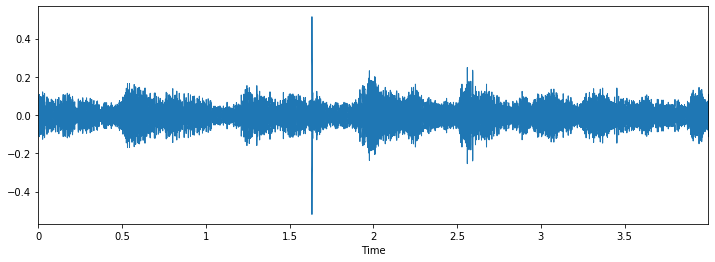

In [203]:
filename = '../Dataset/UrbanSound8K/audio/fold'+str(metadata['fold'][99])+'/'+metadata['slice_file_name'][99]
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

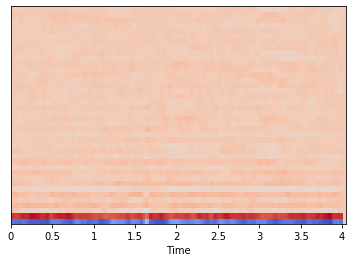

In [204]:
import librosa.display
librosa.display.specshow(X[99], sr=22050, x_axis='time')

In [205]:
activations = activation_model.predict(img_tensor.reshape(1, num_rows, num_columns, num_channels))

In [206]:
np.argmax(activations[8])

9

In [207]:
activations[0].shape

(1, 39, 173, 16)

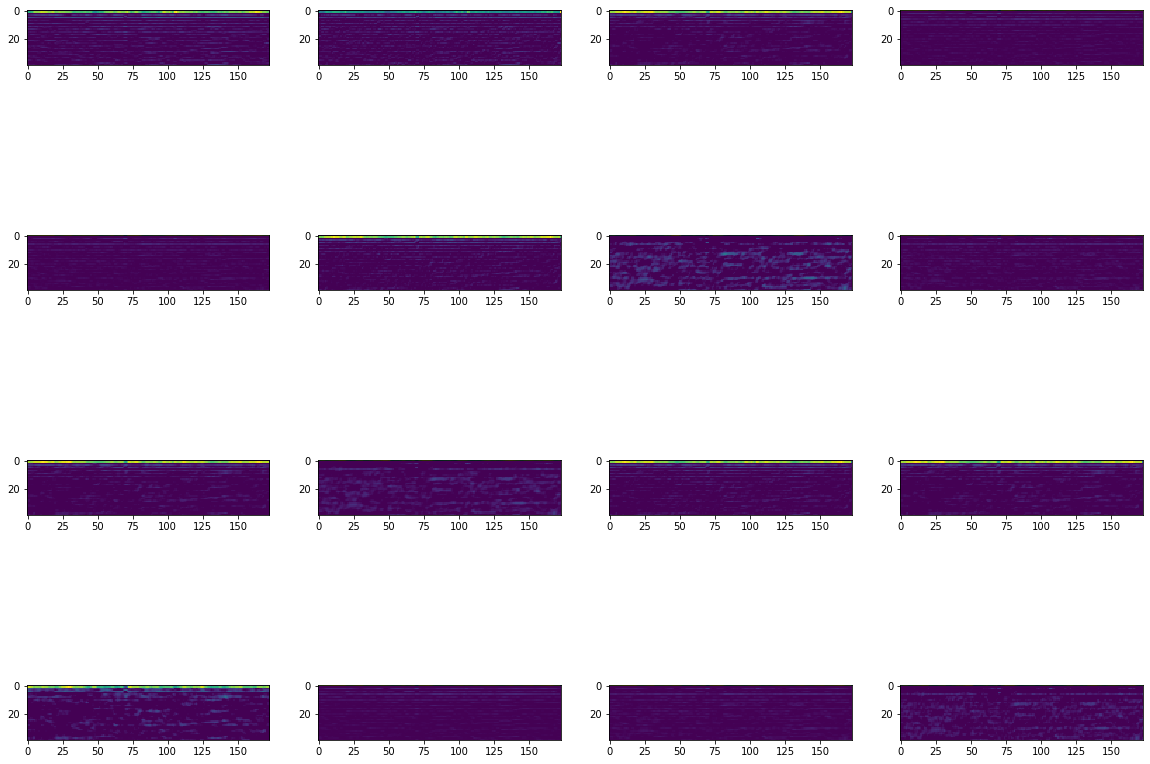

In [208]:
plt.figure(figsize=(20,20))
columns = 4
images = activations[0][0].T
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image.T)

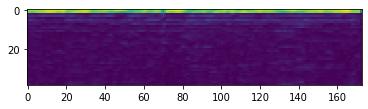

In [213]:
plt.imshow(np.mean(activations[0][0].T, axis = 0).T)

In [214]:
activations[2].shape

(1, 18, 85, 32)

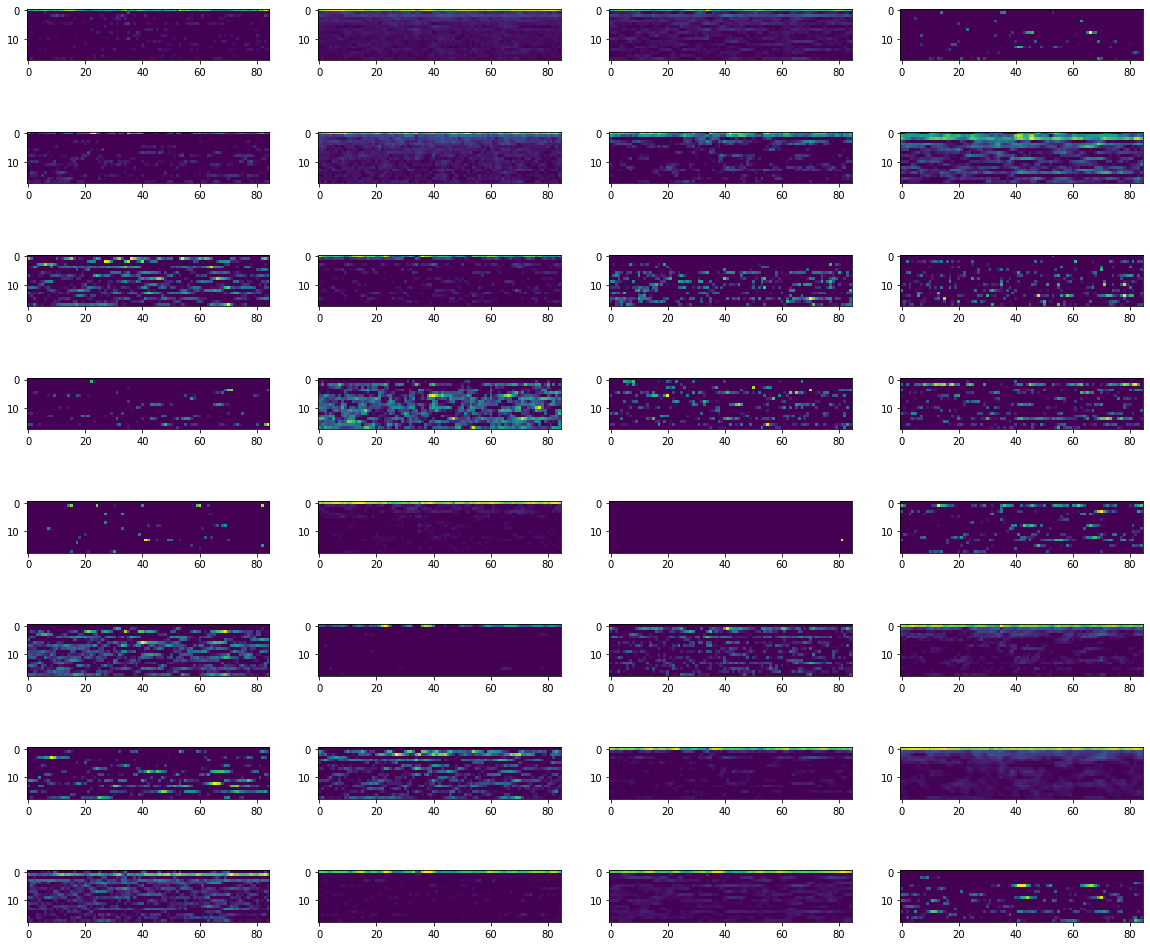

In [215]:
plt.figure(figsize=(20,20))
columns = 4
images = activations[2][0].T
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image.T)

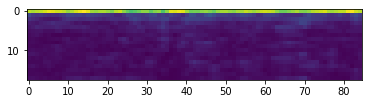

In [216]:
plt.imshow(np.mean(activations[2][0].T, axis = 0).T)

In [217]:
activations[4].shape

(1, 8, 41, 64)

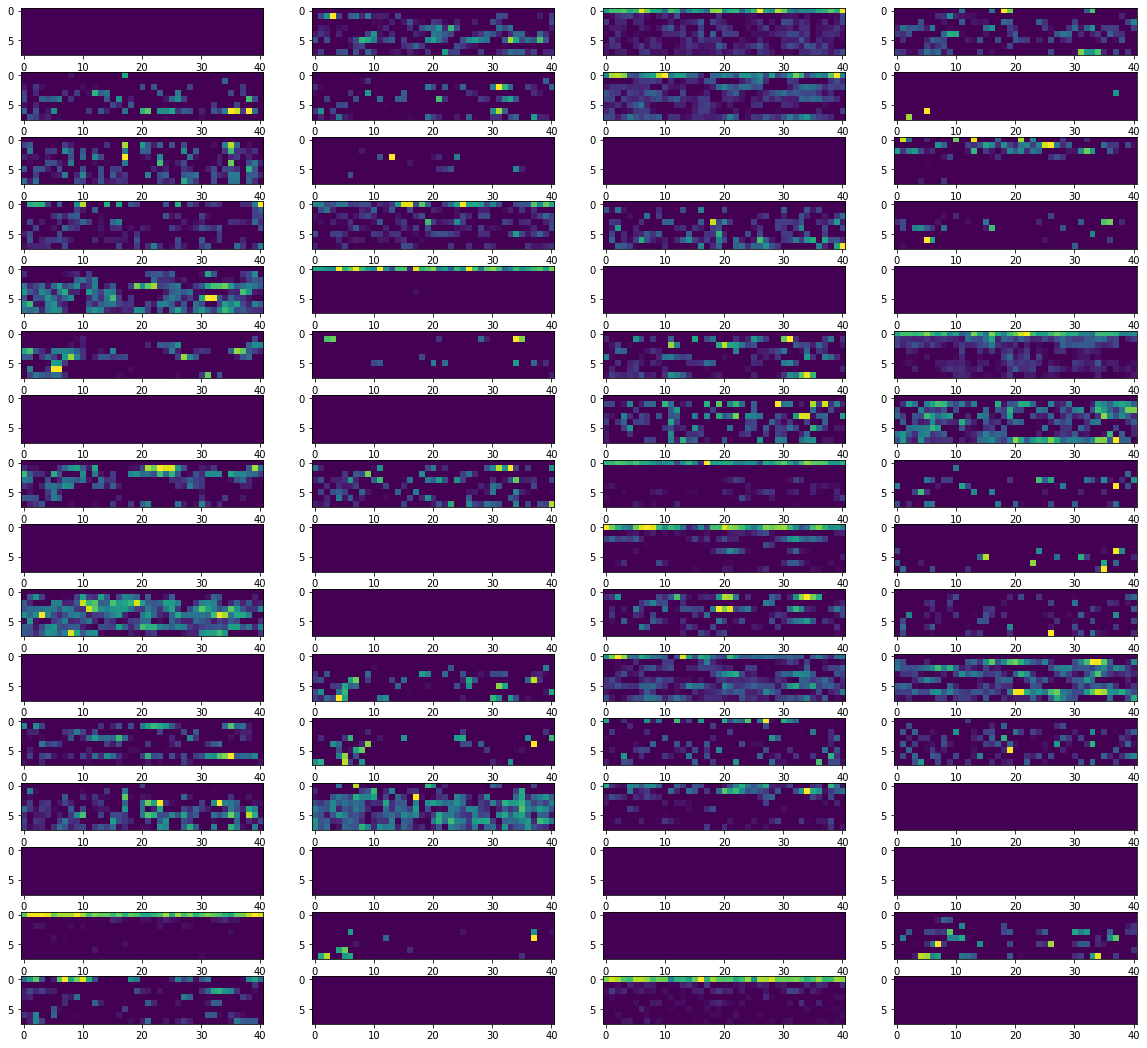

In [218]:
plt.figure(figsize=(20,20))
columns = 4
images = activations[4][0].T
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image.T)

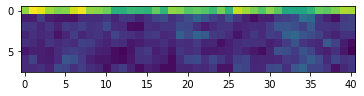

In [219]:
plt.imshow(np.mean(activations[4][0].T, axis = 0).T)

In [220]:
img_tensor = X[0]

In [221]:
y[0]

'dog_bark'

In [222]:
yy[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

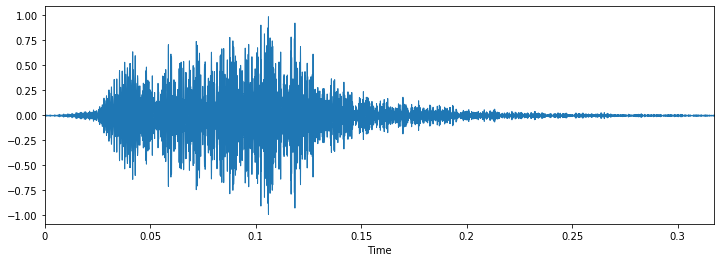

In [223]:
filename = '../Dataset/UrbanSound8K/audio/fold'+str(metadata['fold'][0])+'/'+metadata['slice_file_name'][0]
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

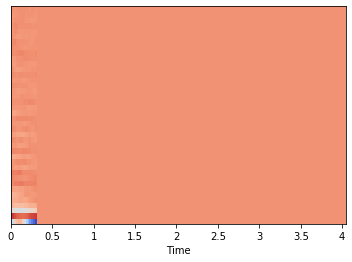

In [224]:
import librosa.display
librosa.display.specshow(X[0], sr=22050, x_axis='time')

In [225]:
activations = activation_model.predict(img_tensor.reshape(1, num_rows, num_columns, num_channels))

In [226]:
np.argmax(activations[8])

3

In [227]:
activations[0].shape

(1, 39, 173, 16)

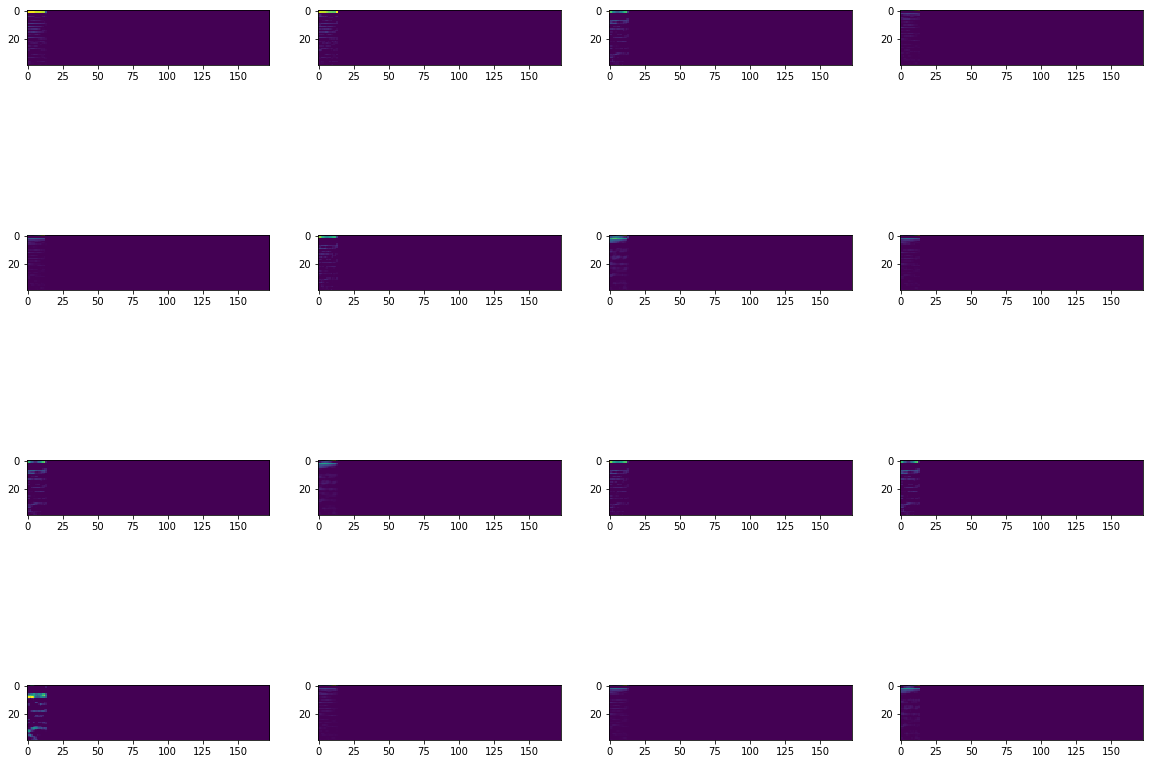

In [228]:
plt.figure(figsize=(20,20))
columns = 4
images = activations[0][0].T
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image.T)

In [229]:
activations[2].shape

(1, 18, 85, 32)

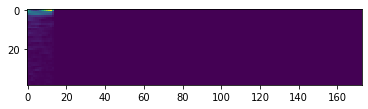

In [230]:
plt.imshow(np.mean(activations[0][0].T, axis = 0).T)

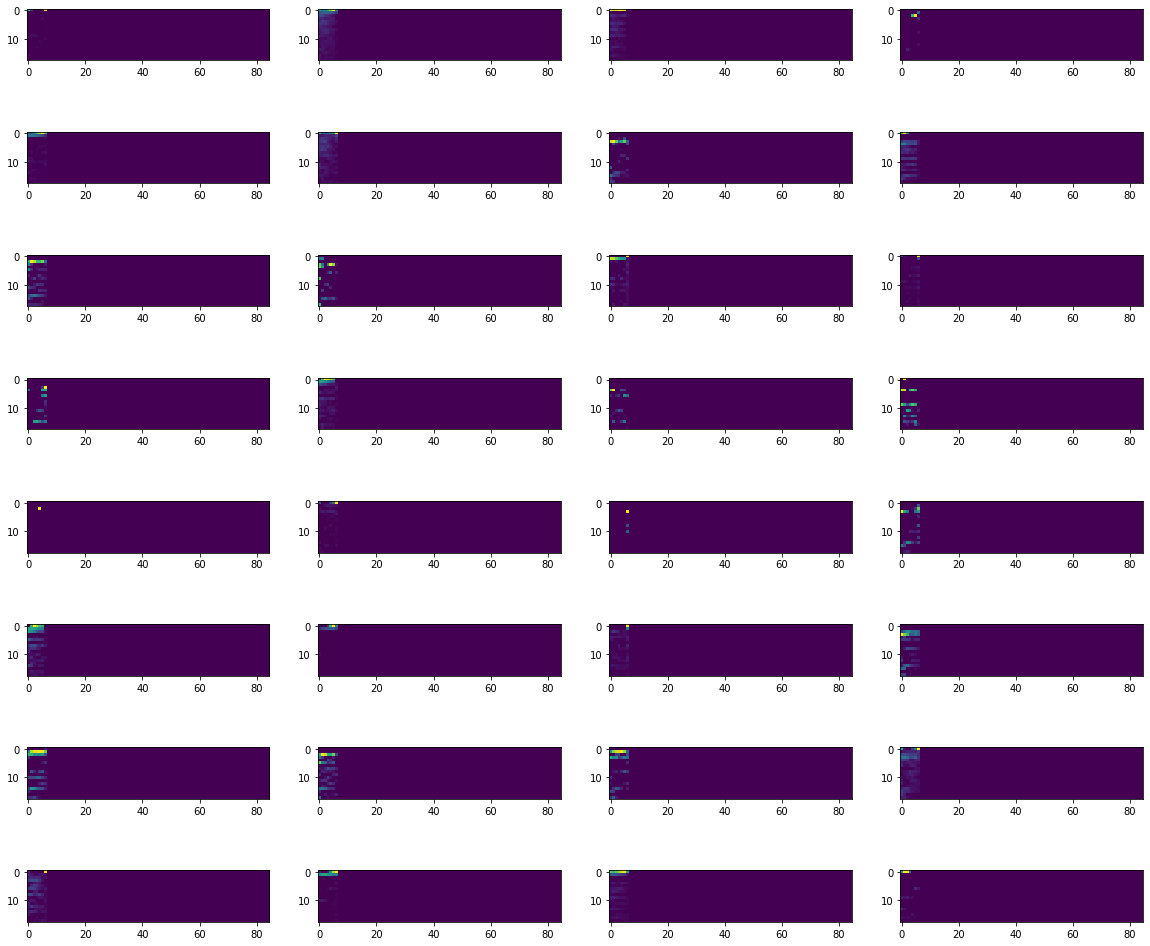

In [231]:
plt.figure(figsize=(20,20))
columns = 4
images = activations[2][0].T
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image.T)

In [234]:
activations[4].shape

(1, 8, 41, 64)

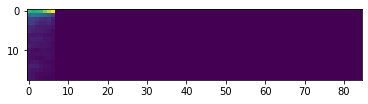

In [233]:
plt.imshow(np.mean(activations[2][0].T, axis = 0).T)

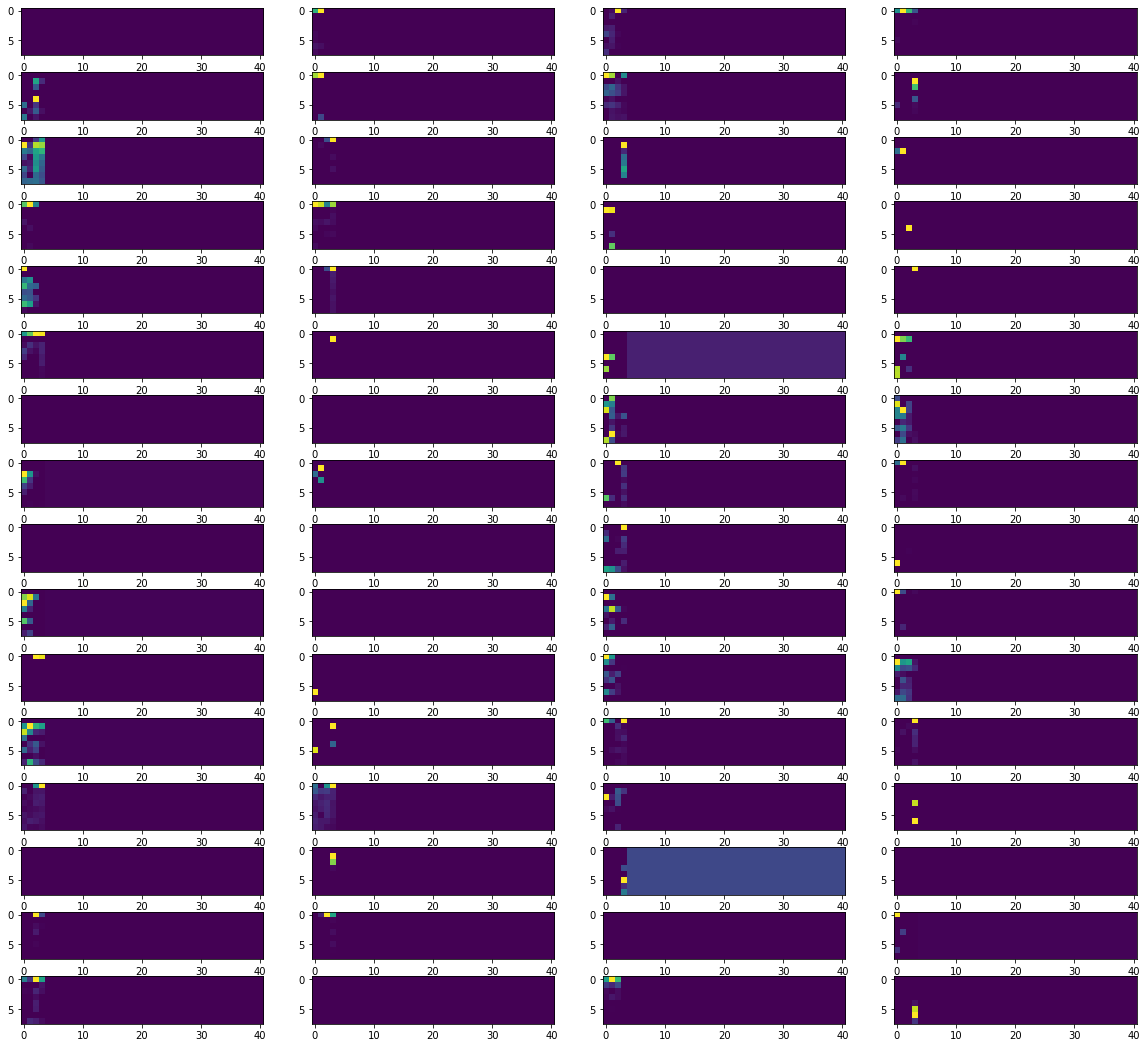

In [235]:
plt.figure(figsize=(20,20))
columns = 4
images = activations[4][0].T
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image.T)

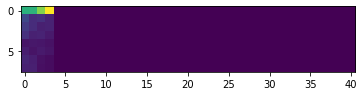

In [236]:
plt.imshow(np.mean(activations[4][0].T, axis = 0).T)

## Visualizing mean activations

In [170]:
activations = activation_model.predict(X.reshape(X.shape[0], num_rows, num_columns, num_channels))

In [171]:
activations[0].shape

(8732, 39, 173, 16)

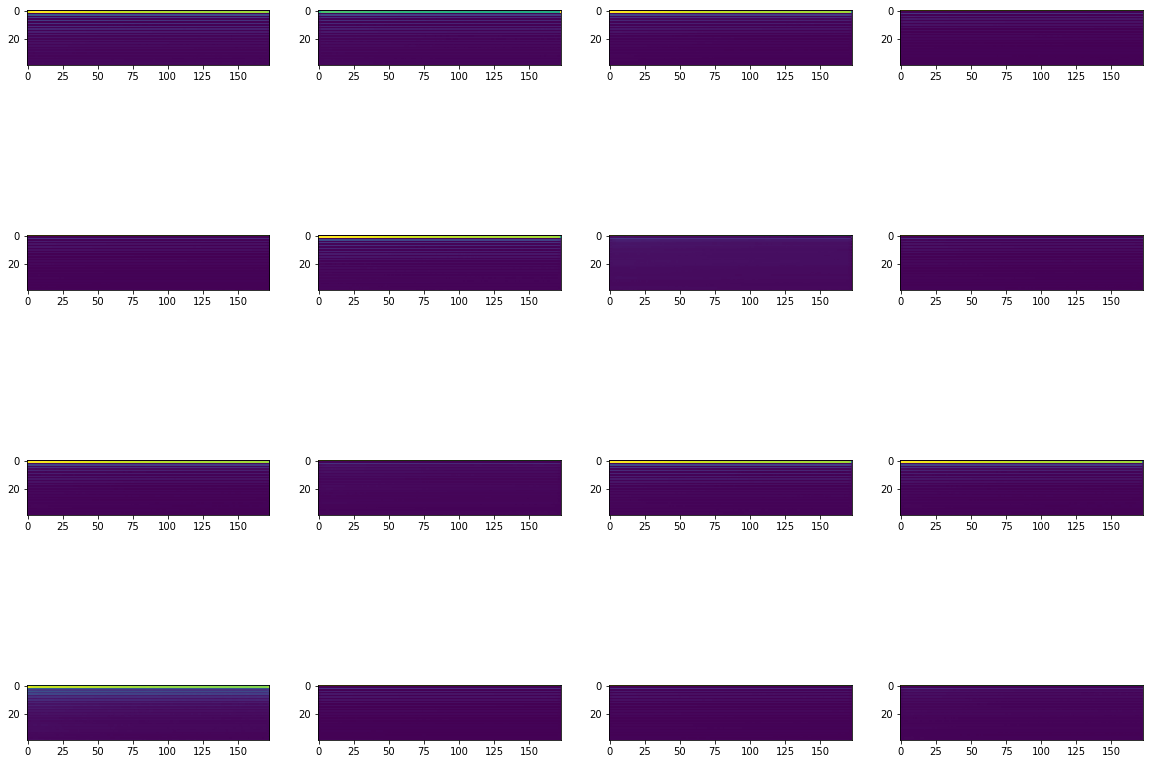

In [174]:
plt.figure(figsize=(20,20))
columns = 4
images = np.mean(activations[0], axis = 0).T
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image.T)

In [175]:
activations[2].shape

(8732, 18, 85, 32)

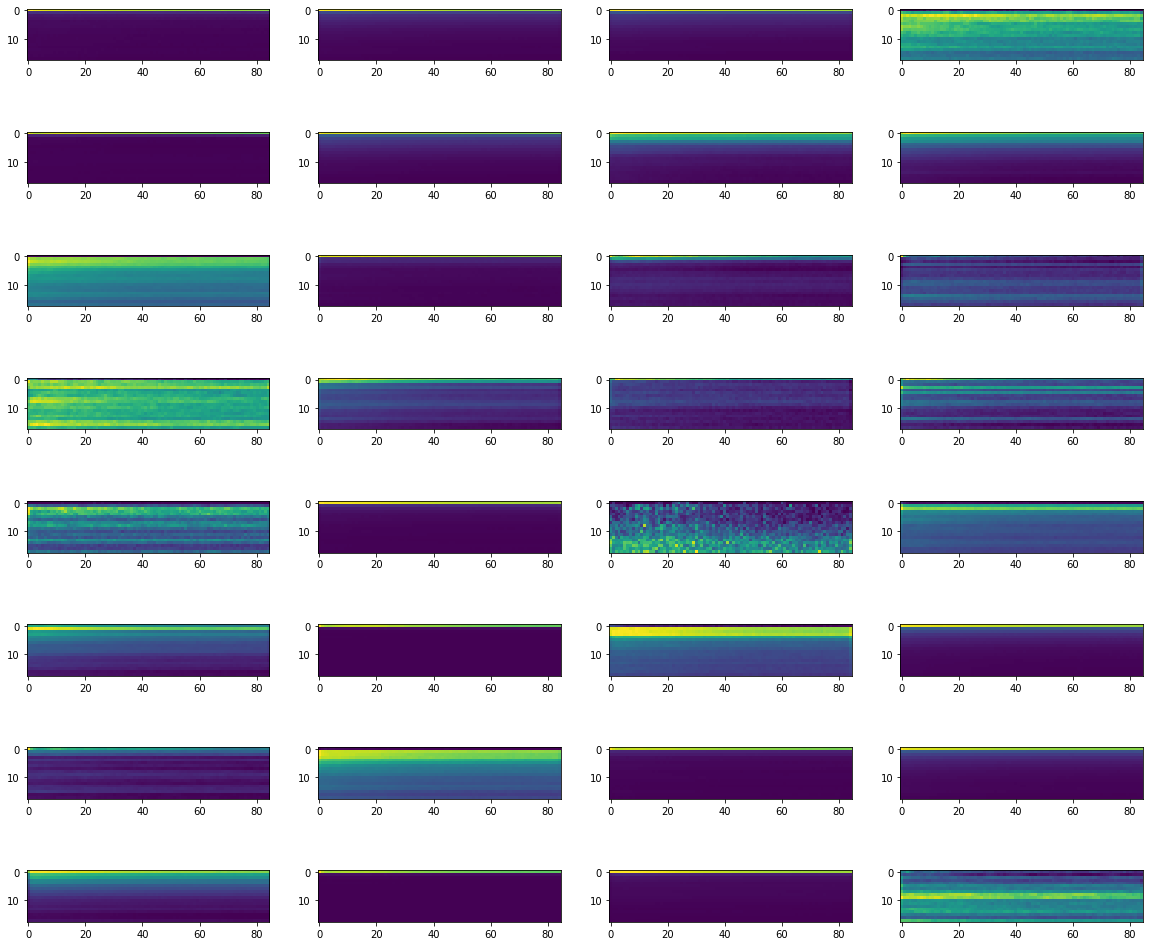

In [176]:
plt.figure(figsize=(20,20))
columns = 4
images = np.mean(activations[2], axis = 0).T
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image.T)

In [177]:
activations[4].shape

(8732, 8, 41, 64)

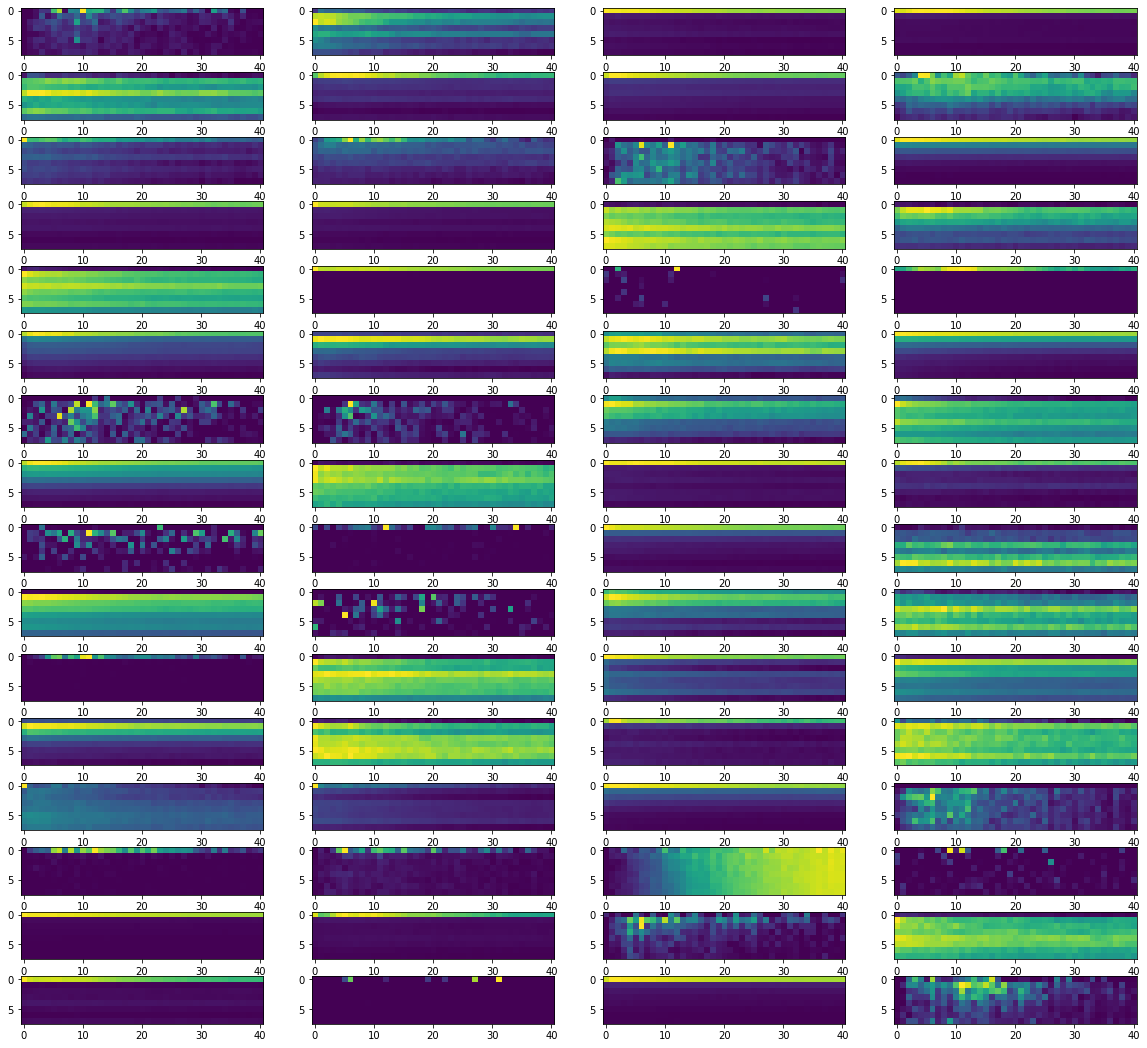

In [178]:
plt.figure(figsize=(20,20))
columns = 4
images = np.mean(activations[4], axis = 0).T
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image.T)